<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta pràctica aprendrem a detectar la intenció de l'usuari a partir d'interaccions reals amb un xatbot. En el context de xatbots, la classificació d'intencions ajuda a entendre quina acció o resposta hauria de prendre el sistema en funció de la consulta de l'usuari.  


<p> ✨ <b>Contingut</b>: en primer lloc, farem servir una base de dades amb oracions d'interaccions en espanyol etiquetades com 19 intencions diferents. En segon lloc, realitzarem el preprocessament de les dades, és a dir, transformarem les dades perquè tinguen un format adequat per a ser introduïdes al model. I finalment, dissenyarem i entrenarem el model de classificació per detectar automàticament la intenció de les oracions.</p>  


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>



Notebook realitzat per:
- Marta Juncarol Pi
- Jaume Mora Ladària
- Abril Risso Matas

---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
2. [Preprocessament de dades](#section-two)
  * [Exercici 2](#ex-two)
  * [Exercici 3](#ex-three)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 4](#ex-four)
  * [Exercici 5](#ex-five)
4. [Lliurable](#section-four)
---

In [ ]:
import random
import itertools
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.utils import compute_class_weight

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D, LayerNormalization

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abril\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abril\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abril\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\abril\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip
Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: c:\Users\abril\Downloads\nlu_ATIS_data.tar.gz

  0%|          | 0.00/122k [00:00<?, ?B/s]
100%|██████████| 122k/122k [00:00<00:00, 2.09MB/s]


<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [3]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


Per a aquesta primera part de la pràctica ens centrarem en la primera columna dels arxius que correspon amb les **oracions** en anglès introduïdes per l'usuari. I en la tercera columna que correspon amb la **intenció** de cada oració, és a dir, cada oració tindrà una etiqueta.

Podeu executar la cel·la següent tantes vegades com vulgueu per veure instàncies d'aquest conjunt de dades.


In [4]:
random_number = random.randint(0, len(train_data)-1)

train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[2])
train_labels = list(s.replace(' ', '') for s in train_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Sentence:  i 'd like to go from boston to denver at 9 o'clock saturday night
Intent:  flight


A continuació analitzarem quantes etiquetes diferents hi ha al dataset i quines són.

In [5]:
num_labels = 0
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

print(f'\nThere are a total of {num_labels} intent labels')

Label 0: cheapest
Label 1: airfare+flight_time
Label 2: airfare
Label 3: airport
Label 4: aircraft+flight+flight_no
Label 5: aircraft
Label 6: meal
Label 7: quantity
Label 8: flight_no
Label 9: airline
Label 10: distance
Label 11: ground_service+ground_fare
Label 12: ground_fare
Label 13: city
Label 14: flight+airfare
Label 15: flight_time
Label 16: capacity
Label 17: abbreviation
Label 18: flight
Label 19: restriction
Label 20: ground_service
Label 21: airline+flight_no

There are a total of 22 intent labels


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

En primer lloc, haurem de tokenitzar les oracions. Això consisteix a convertir el text en representacions numèriques, ja que els models esperen unitats discretes.

En aquesta pràctica farem servir una tokenització senzilla, simplement dividirem les oracions en paraules i crearem un vocabulari basat en les paraules úniques de les dades d'entrenament. Cada paraula (token) tindrà assignat un ID únic.

Vegem com queda el vocabulari.

In [6]:
num_words=500
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(train_sentences)

vocab = tokenizer.word_index
print(vocab)

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

En aquest primer exercici us demanem que donat el vocabulari anterior convertiu la llista d'oracions de la partició d'entrenament, és a dir, `train_sentences` en seqüències d'IDs.

Podeu trobar la documentació [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [7]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)

print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [8]:
max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  12  69   1  38   2   9  64 415  84
  17  75  16  13  64 493  16   4  36]


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Com l'ordre de les paraules sí que importa als models que utilitzarem en aquesta pràctica, és aconsellable que el *padding* estiga al final i no al principi. Busqueu [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) com fer perquè el codi anterior afegisca els zeros al final i no al principi de la seqüència.

In [9]:
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


---

A continuació convertirem les classes d'intencions categòriques (*capacity*, *ground_service*, *flight*, etc.) en el que anomenem one-hot vector encoding. Aquesta tècnica s'utilitza per representar les dades categòriques com a vectors binaris. On cada vector representa una classe específica i l'element corresponent a la classe es posa a 1 i la resta d'elements es mantenen a 0.

Imaginem que tenim tres classes: *capacity*, *ground_service*, *flight*. Podríem codificar aquestes classes amb un vector únic de la forma següent:


```
   capacity -> [1, 0, 0]
   ground_service -> [0, 1, 0]
   flight -> [0, 0, 1]
```

Per aconseguir això primer codificarem les classes d'intenció en etiquetes numèriques.

In [10]:
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot.

In [11]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [12]:
# VAL
val_sentences = list(val_data[0])
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# TEST
test_sentences = list(test_data[0])
test_sentences = tokenizer.texts_to_sequences(test_sentences)
test_pad_sequences = pad_sequences(test_sentences, maxlen=max_sequence_length, padding='post', truncating='post')

In [13]:
val_labels = list(val_data[2])
test_labels = list(test_data[2])
val_labels = list(s.replace('"', '') for s in val_data[2])
val_labels = list(s.replace(' ', '') for s in val_labels)
test_labels = list(s.replace('"', '') for s in test_data[2])
test_labels = list(s.replace(' ', '') for s in test_labels)

def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_list = [item for item in input_list if item not in values_to_remove]
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_list, np.array(cleaned_other_list)

values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline']
val_labels, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)


In [14]:
# VAL
val_numerical_labels = label_encoder.transform(val_labels)
val_encoded_labels = to_categorical(val_numerical_labels, num_classes)
# TEST
test_numerical_labels = label_encoder.transform(test_labels)
test_encoded_labels = to_categorical(test_numerical_labels, num_classes)

---

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [15]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is not available. The model will be trained on CPU.


---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

En aquest exercici haureu de dissenyar l'arquitectura del model. El nostre model tindrà quatre capes:

1. La primera capa serà un **embedding**. Aquesta capa permetrà convertir les dades de text d'entrada, en vectors densos amb una mida fixa (*embedding_dim*). Aquesta representació més compacta permetrà per una part capturar la informació semàntica del text d'entrada, permetent així generalitzar millor i comprendre les relacions entre les paraules. I, per una altra banda, reduir la complexitat computacional, accelerant així el temps d'entrenament i inferència. En resum, aquesta capa assignarà a cada índex de cada paraula un vector dens de mida *embedding_dim*.

2. La segona capa serà un **pooling** layer. L'entrada d'aquesta capa serà un tensor 3D (*batch_size*, *sequence_length*, *embedding_dim*). Aquesta capa es centrarà a capturar la informació més important de la seqüència d'entrada, és a dir, prendrà el valor màxim de la seqüència, donant lloc a un tensor 2D (batch_size, embedding_dim).

3. La tercera capa serà una capa **densa**. És a dir, una capa completament connectada (*fully-connected*): cada neurona d'aquesta capa estarà connectada a totes les neurones de la capa anterior. La funció d'activació que utilitzarem serà una ReLU. Aquesta funció introdueix una no-linealitat al model permetent així aprendre relacions complexes en les dades.

4. L'última capa també serà una capa **densa**. En aquest cas la funció d'activació haurà de ser la funció Softmax. Aquesta funció es fa servir per a convertir els valors de la capa anterior (*logits*) en probabilitats normalitzades. El valor de cada element de sortida representarà la probabilitat que l'entrada pertanya a una classe específica.


📢  Les capes que haureu de fer servir les podreu trobar [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





Podeu veure a continuació les oracions que el model ha classificat incorrectament.

In [16]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


embedding_dim = 100

vocab_size = num_words + 1

model = Sequential()

# 1. Capa embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# 2. Capa de pooling
model.add(GlobalMaxPooling1D())

# 3. Capa densa
model.add(Dense(64, activation='relu'))

# 4. Capa final
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
model.fit(train_pad_sequences, train_encoded_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_encoded_labels))

# Evaluate the model on the validation and test sets
loss_val, accuracy_val = model.evaluate(val_pad_sequences, val_encoded_labels, batch_size=batch_size)
loss_test, accuracy_test = model.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size)

# Calculate F1-score (macro) on validation and test sets
val_predictions = model.predict(val_pad_sequences, batch_size=batch_size)
test_predictions = model.predict(test_pad_sequences, batch_size=batch_size)

val_predicted_labels = np.argmax(val_predictions, axis=1)
test_predicted_labels = np.argmax(test_predictions, axis=1)

val_true_labels = np.argmax(val_encoded_labels, axis=1)
test_true_labels = np.argmax(test_encoded_labels, axis=1)

f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

results_val = {
    'val_accuracy': accuracy_val,
    'f1_score_val': f1_score_val,
    'test_accuracy': accuracy_test,
    'f1_score_test': f1_score_test
}

results_val_df = pd.DataFrame([results_val])
print(results_val_df.to_string(index=False))

Epoch 1/10
128/128 [==============================] - 1s 4ms/step - loss: 1.6188 - accuracy: 0.7224 - val_loss: 1.0450 - val_accuracy: 0.7144
Epoch 2/10
128/128 [==============================] - 0s 3ms/step - loss: 0.8529 - accuracy: 0.7729 - val_loss: 0.7375 - val_accuracy: 0.8433
Epoch 3/10
128/128 [==============================] - 0s 2ms/step - loss: 0.5508 - accuracy: 0.8722 - val_loss: 0.5139 - val_accuracy: 0.8778
Epoch 4/10
128/128 [==============================] - 0s 3ms/step - loss: 0.3838 - accuracy: 0.8995 - val_loss: 0.4061 - val_accuracy: 0.9100
Epoch 5/10
128/128 [==============================] - 0s 2ms/step - loss: 0.2863 - accuracy: 0.9220 - val_loss: 0.3430 - val_accuracy: 0.9133
Epoch 6/10
128/128 [==============================] - 0s 2ms/step - loss: 0.2238 - accuracy: 0.9380 - val_loss: 0.3071 - val_accuracy: 0.9244
Epoch 7/10
128/128 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.9549 - val_loss: 0.2828 - val_accuracy: 0.9278
Epoch 

In [17]:
probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)

for i in range(0, len(predicted_labels)):
  if test_labels[i] != predicted_labels[i]:
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()

28/28 [==============================] - 0s 1ms/step
Sentence:  [10, 8, 17, 281, 121, 56, 1, 100, 5, 116, 42, 53, 16, 100, 147, 163, 35]
Original label:  flight+airfare
Predicted label:  flight

Sentence:  [12, 55, 14, 8, 2, 175, 1, 92]
Original label:  meal
Predicted label:  flight

Sentence:  [12, 55, 14, 8, 2, 92, 1, 122]
Original label:  meal
Predicted label:  flight

Sentence:  [34, 88, 14, 8, 2, 115, 1, 121, 56]
Original label:  airport
Predicted label:  flight

Sentence:  [60, 3, 26, 61, 2, 11, 165, 1, 176, 33, 16, 4, 36, 5, 266, 94]
Original label:  airline
Predicted label:  flight

Sentence:  [6, 20, 4, 133, 8, 2, 22, 1, 45, 31, 206, 301]
Original label:  city
Predicted label:  aircraft

Sentence:  [10, 7, 8, 113, 2, 128, 1, 99, 5, 79, 17, 8, 113, 2, 99, 1, 168, 5, 79, 17, 8, 160, 2, 168, 1, 128]
Original label:  airline
Predicted label:  flight

Sentence:  [12, 55, 1, 162, 2, 184, 1, 13, 5, 155, 293, 147, 146, 35]
Original label:  ground_fare
Predicted label:  airfare

Senten

---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.

 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

Funcions de preprocessament

In [17]:
def preprocessing(texts, vocab_size=5000, lowercase=False, lemmatize=False, stem=False, stop_words=False):
    tokenizer = Tokenizer(num_words=vocab_size, lower=lowercase)
    tokenizer.fit_on_texts(texts)

    lemmatizer_obj = WordNetLemmatizer() if lemmatize else None
    stemmer = PorterStemmer() if stem else None
    stopword = set(stopwords.words('english')) if stop_words else set()

    processed_texts = []
    for text in texts:
        text = text.lower() if lowercase else text
        tokens = nltk.word_tokenize(text)
        if lemmatize:
            tokens = [lemmatizer_obj.lemmatize(token) for token in tokens]
        if stem:
            tokens = [stemmer.stem(token) for token in tokens]
        tokens = [token for token in tokens if token not in stopword and token.isalpha()]
        processed_texts.append(" ".join(tokens))

    return processed_texts, tokenizer

In [18]:
def process_val_test(val, test, label_encoder):

    # Preprocessem les dades de validació
    val_sentences = list(val[0])
    val_sequences = tokenizer.texts_to_sequences(val_sentences)
    val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

    # Preprocessem les dades de test
    test_sentences = list(test[0])
    test_sequences = tokenizer.texts_to_sequences(test_sentences)
    test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

    # Encode les etiquetes de validació i test
    val_labels = list(val[2])
    test_labels = list(test[2])
    val_labels = list(s.replace('"', '') for s in val[2])
    val_labels = list(s.replace(' ', '') for s in val_labels)
    test_labels = list(s.replace('"', '') for s in test[2])
    test_labels = list(s.replace(' ', '') for s in test_labels)

    def remove_values_and_indices(input_list, values_to_remove, other_list):
        indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
        cleaned_list = [item for item in input_list if item not in values_to_remove]
        cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
        return cleaned_list, np.array(cleaned_other_list)

    values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline']
    val_labels, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
    test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)

    val_numerical_labels = label_encoder.transform(val_labels)
    val_encoded_labels = to_categorical(val_numerical_labels, num_classes)

    test_numerical_labels = label_encoder.transform(test_labels)
    test_encoded_labels = to_categorical(test_numerical_labels, num_classes)

    return val_pad_sequences, val_encoded_labels, test_pad_sequences, test_encoded_labels

Funció per visualitzar corbes

In [ ]:
def plot_curves(history):
    # Comprovem que els valors de pèrdua i precisió existeixen al diccionari history.history
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    train_accuracy = history.history.get('accuracy', [])
    val_accuracy = history.history.get('val_accuracy', [])
    epochs = range(1, len(train_loss) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Pèrdua d'entrenament i validació
    axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
    axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Precisió d'entrenament i validació
    axes[1].plot(epochs, train_accuracy, 'g-', label='Training Accuracy')
    axes[1].plot(epochs, val_accuracy, 'orange', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

### 1. Balancejat de les classes

Balancejem les classes prèviament a fer la tria de paràmetres del preprocessament ja que d'aquesta manera ens assegurem evitar biaixos en l'avaluació dels paràmetres.

In [22]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


embedding_dim = 100

vocab_size = num_words + 1

model = Sequential()

# 1. Capa embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# 2. Capa de pooling
model.add(GlobalMaxPooling1D())

# 3. Capa densa
model.add(Dense(64, activation='relu'))

# 4. Capa final
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculem els pesos de les classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(train_encoded_labels, axis=1)), y=np.argmax(train_encoded_labels, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# Comptem el nombre d'exemples per cada classe
class_counts = np.bincount(np.argmax(train_encoded_labels, axis=1))  # Això compta quantes mostres té cada classe
total_samples = len(train_encoded_labels)  # Nombre total de mostres

# Calculem els pesos per a cada classe com la inversa de la freqüència relativa
manual_class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

# Train the model
batch_size = 32
epochs = 10

model.fit(train_pad_sequences, train_encoded_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_encoded_labels), class_weight=manual_class_weights)

# Evaluate the model on the validation and test sets
loss_val, accuracy_val = model.evaluate(val_pad_sequences, val_encoded_labels, batch_size=batch_size)
loss_test, accuracy_test = model.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size)

# Calculate F1-score (macro) on validation and test sets
val_predictions = model.predict(val_pad_sequences, batch_size=batch_size)
test_predictions = model.predict(test_pad_sequences, batch_size=batch_size)

val_predicted_labels = np.argmax(val_predictions, axis=1)
test_predicted_labels = np.argmax(test_predictions, axis=1)

val_true_labels = np.argmax(val_encoded_labels, axis=1)
test_true_labels = np.argmax(test_encoded_labels, axis=1)

f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

results_val = {
    'val_accuracy': accuracy_val,
    'f1_score_val': f1_score_val,
    'test_accuracy': accuracy_test,
    'f1_score_test': f1_score_test
}

results_val_df = pd.DataFrame([results_val])
print(results_val_df.to_string(index=False))


Epoch 1/10
128/128 [==============================] - 1s 3ms/step - loss: 68.1882 - accuracy: 0.2075 - val_loss: 2.8593 - val_accuracy: 0.7844
Epoch 2/10
128/128 [==============================] - 0s 2ms/step - loss: 65.8531 - accuracy: 0.8443 - val_loss: 2.5538 - val_accuracy: 0.8544
Epoch 3/10
128/128 [==============================] - 0s 3ms/step - loss: 60.9363 - accuracy: 0.8722 - val_loss: 1.9592 - val_accuracy: 0.8589
Epoch 4/10
128/128 [==============================] - 0s 3ms/step - loss: 51.2526 - accuracy: 0.8845 - val_loss: 1.4478 - val_accuracy: 0.8489
Epoch 5/10
128/128 [==============================] - 0s 3ms/step - loss: 41.9348 - accuracy: 0.8803 - val_loss: 1.1129 - val_accuracy: 0.8544
Epoch 6/10
128/128 [==============================] - 0s 3ms/step - loss: 31.6017 - accuracy: 0.8919 - val_loss: 0.8305 - val_accuracy: 0.8667
Epoch 7/10
128/128 [==============================] - 0s 3ms/step - loss: 22.8171 - accuracy: 0.9012 - val_loss: 0.6284 - val_accuracy: 0.8778

### 2. Preprocessament

Amb el model anterior, un cop les classes ja estan balancejades, provem d'afegir nous passos al preprocessament.

In [23]:
def model(X_train, X_val, X_test, y_train, y_val, y_test, vocab_size, embedding_dim, max_sequence_length, num_classes):

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Calculem els pesos de les classes
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
    class_weight_dict = dict(enumerate(class_weights))

    # Comptem el nombre d'exemples per cada classe
    class_counts = np.bincount(np.argmax(y_train, axis=1))  # Això compta quantes mostres té cada classe
    total_samples = len(y_train)  # Nombre total de mostres

    # Calculem els pesos per a cada classe com la inversa de la freqüència relativa
    manual_class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

    # Train the model
    batch_size = 32
    epochs = 10

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), class_weight=manual_class_weights)

    # Evaluate
    loss_val, accuracy_val = model.evaluate(X_val, y_val, batch_size=batch_size)
    loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=batch_size)

    # F1-SCORE
    val_true_labels = np.argmax(val_encoded_labels, axis=1)
    test_true_labels = np.argmax(test_encoded_labels, axis=1)

    val_predictions = model.predict(val_pad_sequences, batch_size=32)
    test_predictions = model.predict(test_pad_sequences, batch_size=32)

    val_predicted_labels = np.argmax(val_predictions, axis=1)
    test_predicted_labels = np.argmax(test_predictions, axis=1)

    f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
    f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

    return accuracy_val, accuracy_test, f1_score_val, f1_score_test, history

In [24]:
# Paràmetres que volem provar
lowercase_options = [True, False]
lemmatize_options = [True, False]
stem_options = [True, False]
stop_words_options = [True, False]
vocab_sizes = [5000, 10000, 20000]

# Generar totes les combinacions possibles
param_combinations = list(itertools.product(lowercase_options, lemmatize_options, stem_options, stop_words_options, vocab_sizes))

In [25]:
# Importem les dades de train, val i test
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)  # Les últimes 900 files per al conjunt de validació
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)  # Redefinim el conjunt de train amb les primeres 4078 files
test_data = pd.read_csv('./data/test.csv', header=None)  # Importem les dades de test

# Preprocessem les etiquetes i frases del conjunt de train
train_sentences = list(train_data[0])
train_labels = [s.replace('"', '').replace(' ', '') for s in train_data[2]]

results = []  

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42) 

for params in param_combinations:
    lowercase, lemmatize, stem, stop_words, vocab_size = params

    prep_train, tokenizer = preprocessing(train_sentences, vocab_size, lowercase, lemmatize, stem, stop_words)

    # PROCESSEM PER FER LES PREDICCIONS
    # Convertim les frases en seqüències numèriques
    train_sequences = tokenizer.texts_to_sequences(prep_train)
    max_sequence_length = max(map(len, train_sequences))

    # Paddegem les seqüències per fer-les de la mateixa longitud
    train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

    # Encode les etiquetes del conjunt de train a valors numèrics
    label_encoder = LabelEncoder()
    train_numerical_labels = label_encoder.fit_transform(train_labels)
    num_classes = len(np.unique(train_numerical_labels))
    train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

    val_pad_sequences, val_encoded_labels, test_pad_sequences, test_encoded_labels = process_val_test(val_data, test_data, label_encoder) 
    
    # ENTRENEM EL MODEL
    embedding_dim = 100
    val_accuracy, test_accuracy, f1_score_val, f1_score_test, history = model(train_pad_sequences, val_pad_sequences, test_pad_sequences, train_encoded_labels, val_encoded_labels, test_encoded_labels,
                        vocab_size+1, embedding_dim, max_sequence_length, num_classes)
    results.append({
        'lowercase': lowercase,
        'lemmatize': lemmatize,
        'stem': stem,
        'stop_words': stop_words,
        'vocab_size': vocab_size,
        'val_accuracy': val_accuracy,
        'f1_score_val': f1_score_val,
        'test_accuracy': test_accuracy,
        'f1_score_test': f1_score_test
    })

Epoch 1/10
128/128 [==============================] - 1s 7ms/step - loss: 67.8827 - accuracy: 0.3798 - val_loss: 2.8587 - val_accuracy: 0.7633
Epoch 2/10
128/128 [==============================] - 1s 6ms/step - loss: 64.5289 - accuracy: 0.8641 - val_loss: 2.6151 - val_accuracy: 0.7222
Epoch 3/10
128/128 [==============================] - 1s 6ms/step - loss: 59.1280 - accuracy: 0.8521 - val_loss: 2.3507 - val_accuracy: 0.6933
Epoch 4/10
128/128 [==============================] - 1s 6ms/step - loss: 48.1878 - accuracy: 0.8565 - val_loss: 2.2955 - val_accuracy: 0.4889
Epoch 5/10
128/128 [==============================] - 1s 6ms/step - loss: 38.2963 - accuracy: 0.8073 - val_loss: 2.2901 - val_accuracy: 0.3667
Epoch 6/10
128/128 [==============================] - 1s 6ms/step - loss: 28.9788 - accuracy: 0.7658 - val_loss: 2.2721 - val_accuracy: 0.3144
Epoch 7/10
128/128 [==============================] - 1s 6ms/step - loss: 22.1788 - accuracy: 0.7962 - val_loss: 2.2460 - val_accuracy: 0.3244

In [26]:
# Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

 lowercase  lemmatize  stem  stop_words  vocab_size  val_accuracy  f1_score_val  test_accuracy  f1_score_test
      True      False False       False       20000      0.883333      0.663590       0.899775       0.616873
     False      False False       False        5000      0.852222      0.655276       0.879505       0.543667
      True      False False       False       10000      0.855556      0.646920       0.896396       0.617211
      True      False False       False        5000      0.858889      0.611001       0.888514       0.566394
     False      False False       False       10000      0.861111      0.590782       0.894144       0.566451
     False      False False       False       20000      0.863333      0.540111       0.911036       0.590640
     False      False False        True        5000      0.670000      0.485637       0.757883       0.472464
      True       True False       False       10000      0.670000      0.470750       0.698198       0.406969
     False

### 2. Dimensió de l'embedding

Amb la nova configuració de paràmetres, tornem a definir la funció de preprocessing.

In [20]:
def preprocessing(texts, vocab_size=20000, lowercase=True, lemmatize=False, stem=False, stop_words=False):
    tokenizer = Tokenizer(num_words=vocab_size, lower=lowercase)
    tokenizer.fit_on_texts(texts)

    lemmatizer_obj = WordNetLemmatizer() if lemmatize else None
    stemmer = PorterStemmer() if stem else None
    stopword = set(stopwords.words('english')) if stop_words else set()

    processed_texts = []
    for text in texts:
        text = text.lower() if lowercase else text
        tokens = nltk.word_tokenize(text)
        if lemmatize:
            tokens = [lemmatizer_obj.lemmatize(token) for token in tokens]
        if stem:
            tokens = [stemmer.stem(token) for token in tokens]
        tokens = [token for token in tokens if token not in stopword and token.isalpha()]
        processed_texts.append(" ".join(tokens))

    return processed_texts, tokenizer

In [21]:
# Importem les dades de train, val i test
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)  # Les últimes 900 files per al conjunt de validació
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)  # Redefinim el conjunt de train amb les primeres 4078 files
test_data = pd.read_csv('./data/test.csv', header=None)  # Importem les dades de test

# Preprocessem les etiquetes i frases del conjunt de train
train_sentences = list(train_data[0])
train_labels = [s.replace('"', '').replace(' ', '') for s in train_data[2]]

prep_train, tokenizer = preprocessing(train_sentences)

# PROCESSEM PER FER LES PREDICCIONS
# Convertim les frases en seqüències numèriques
train_sequences = tokenizer.texts_to_sequences(prep_train)
max_sequence_length = max(map(len, train_sequences))

# Paddegem les seqüències per fer-les de la mateixa longitud
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Encode les etiquetes del conjunt de train a valors numèrics
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

val_pad_sequences, val_encoded_labels, test_pad_sequences, test_encoded_labels = process_val_test(val_data, test_data, label_encoder)

In [29]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

embeddings = [50, 100, 150, 200, 500]
results = []

for emb in embeddings:
  accuracy_val, accuracy_test, f1_score_val, f1_score_test, history = model(train_pad_sequences, val_pad_sequences, test_pad_sequences, train_encoded_labels, val_encoded_labels, test_encoded_labels,
                        20000+1, emb, max_sequence_length, num_classes)
  results.append({
        'embedding dim': emb,
        'val_accuracy': accuracy_val,
        'f1_score_val': f1_score_val,
        'test_accuracy': accuracy_test,
        'f1_score_test': f1_score_test
    })

Epoch 1/10
128/128 [==============================] - 2s 12ms/step - loss: 68.1357 - accuracy: 0.1270 - val_loss: 2.9914 - val_accuracy: 0.5189
Epoch 2/10
128/128 [==============================] - 1s 10ms/step - loss: 66.5947 - accuracy: 0.7727 - val_loss: 2.7496 - val_accuracy: 0.8378
Epoch 3/10
128/128 [==============================] - 1s 11ms/step - loss: 63.2226 - accuracy: 0.8605 - val_loss: 2.2922 - val_accuracy: 0.8589
Epoch 4/10
128/128 [==============================] - 1s 10ms/step - loss: 55.2443 - accuracy: 0.8676 - val_loss: 1.6436 - val_accuracy: 0.8311
Epoch 5/10
128/128 [==============================] - 1s 11ms/step - loss: 46.7432 - accuracy: 0.8595 - val_loss: 1.2899 - val_accuracy: 0.8311
Epoch 6/10
128/128 [==============================] - 1s 10ms/step - loss: 37.2077 - accuracy: 0.8678 - val_loss: 0.9654 - val_accuracy: 0.8422
Epoch 7/10
128/128 [==============================] - 1s 10ms/step - loss: 29.0570 - accuracy: 0.8801 - val_loss: 0.7825 - val_accuracy:

In [30]:
# Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

 embedding dim  val_accuracy  f1_score_val  test_accuracy  f1_score_test
           500      0.918889      0.713261       0.916667       0.628559
           150      0.902222      0.691711       0.911036       0.572827
           100      0.870000      0.624318       0.907658       0.600048
           200      0.910000      0.612682       0.923423       0.689654
            50      0.844444      0.608882       0.868243       0.638362


### 3. Convolucionals

Provem diferents configuracions amb xarxes convolucionals.

In [22]:
def model(X_train, X_val, X_test, y_train, y_val, y_test, vocab_size, embedding_dim, max_sequence_length, num_classes, config):

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

    if config == 2:
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

    elif config == 3:
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

    elif config == 4:
      model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
      model.add(MaxPooling1D(pool_size=2))

    elif config == 5:
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
        model.add(GlobalAveragePooling1D())

    elif config == 6:
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
        model.add(GlobalAveragePooling1D())

    if config != 5 and config != 6:
        model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Calculem els pesos de les classes
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
    class_weight_dict = dict(enumerate(class_weights))

    # Comptem el nombre d'exemples per cada classe
    class_counts = np.bincount(np.argmax(y_train, axis=1))  # Això compta quantes mostres té cada classe
    total_samples = len(y_train)  # Nombre total de mostres

    # Calculem els pesos per a cada classe com la inversa de la freqüència relativa
    manual_class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

    # Train the model
    batch_size = 32
    epochs = 10
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), class_weight=manual_class_weights)

    # Evaluate
    loss_val, accuracy_val = model.evaluate(X_val, y_val, batch_size=batch_size)
    loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=batch_size)

    # F1-SCORE
    val_true_labels = np.argmax(val_encoded_labels, axis=1)
    test_true_labels = np.argmax(test_encoded_labels, axis=1)

    val_predictions = model.predict(val_pad_sequences, batch_size=32)
    test_predictions = model.predict(test_pad_sequences, batch_size=32)

    val_predicted_labels = np.argmax(val_predictions, axis=1)
    test_predicted_labels = np.argmax(test_predictions, axis=1)

    f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
    f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

    return accuracy_val, accuracy_test, f1_score_val, f1_score_test, history

Epoch 1/10
128/128 [==============================] - 19s 141ms/step - loss: 68.9622 - accuracy: 0.0763 - val_loss: 2.8889 - val_accuracy: 0.5367
Epoch 2/10
128/128 [==============================] - 21s 165ms/step - loss: 65.3113 - accuracy: 0.6376 - val_loss: 2.3724 - val_accuracy: 0.8800
Epoch 3/10
128/128 [==============================] - 16s 126ms/step - loss: 58.6147 - accuracy: 0.8377 - val_loss: 1.8712 - val_accuracy: 0.8856
Epoch 4/10
128/128 [==============================] - 17s 133ms/step - loss: 44.9363 - accuracy: 0.8771 - val_loss: 1.2526 - val_accuracy: 0.8478
Epoch 5/10
128/128 [==============================] - 15s 119ms/step - loss: 32.9332 - accuracy: 0.8926 - val_loss: 0.9351 - val_accuracy: 0.8456
Epoch 6/10
128/128 [==============================] - 17s 130ms/step - loss: 18.8750 - accuracy: 0.9186 - val_loss: 0.7371 - val_accuracy: 0.8400
Epoch 7/10
128/128 [==============================] - 15s 119ms/step - loss: 10.7134 - accuracy: 0.9240 - val_loss: 0.4671 -

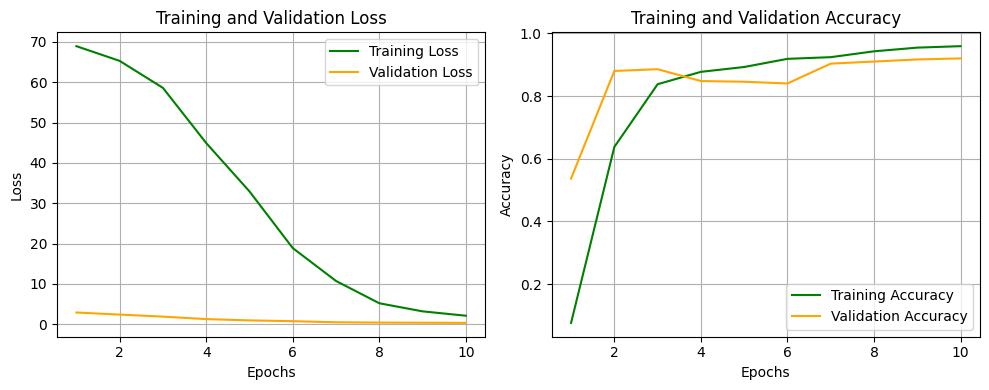

Epoch 1/10
128/128 [==============================] - 22s 162ms/step - loss: 66.5584 - accuracy: 0.1118 - val_loss: 2.7556 - val_accuracy: 0.1922
Epoch 2/10
128/128 [==============================] - 18s 143ms/step - loss: 48.3572 - accuracy: 0.4765 - val_loss: 1.7584 - val_accuracy: 0.6433
Epoch 3/10
128/128 [==============================] - 18s 138ms/step - loss: 27.1112 - accuracy: 0.8298 - val_loss: 1.1523 - val_accuracy: 0.8122
Epoch 4/10
128/128 [==============================] - 17s 134ms/step - loss: 8.4716 - accuracy: 0.8926 - val_loss: 0.5506 - val_accuracy: 0.8889
Epoch 5/10
128/128 [==============================] - 19s 151ms/step - loss: 3.9606 - accuracy: 0.9328 - val_loss: 0.4193 - val_accuracy: 0.9211
Epoch 6/10
128/128 [==============================] - 20s 158ms/step - loss: 1.4423 - accuracy: 0.9564 - val_loss: 0.2668 - val_accuracy: 0.9422
Epoch 7/10
128/128 [==============================] - 19s 148ms/step - loss: 0.8390 - accuracy: 0.9669 - val_loss: 0.2503 - val

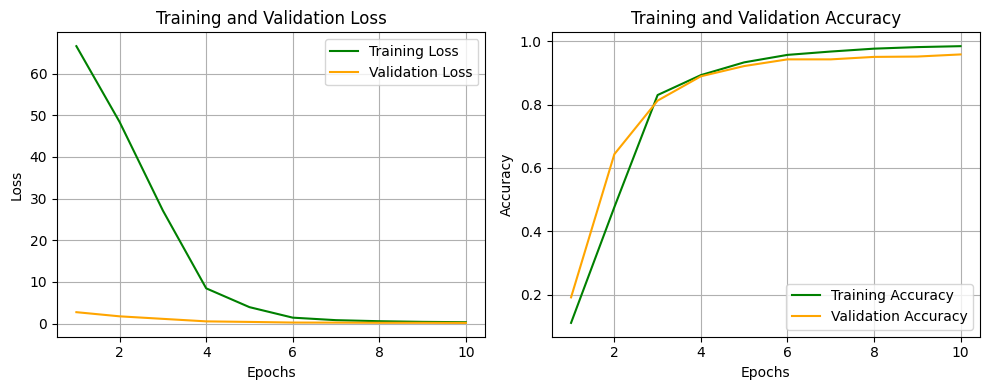

Epoch 1/10
128/128 [==============================] - 19s 139ms/step - loss: 69.3752 - accuracy: 0.0750 - val_loss: 2.9875 - val_accuracy: 0.0600
Epoch 2/10
128/128 [==============================] - 17s 133ms/step - loss: 61.6751 - accuracy: 0.1694 - val_loss: 2.3590 - val_accuracy: 0.1778
Epoch 3/10
128/128 [==============================] - 20s 155ms/step - loss: 52.5819 - accuracy: 0.4875 - val_loss: 1.6411 - val_accuracy: 0.7667
Epoch 4/10
128/128 [==============================] - 21s 167ms/step - loss: 34.1404 - accuracy: 0.6910 - val_loss: 1.0681 - val_accuracy: 0.7256
Epoch 5/10
128/128 [==============================] - 21s 165ms/step - loss: 21.0821 - accuracy: 0.7982 - val_loss: 0.6910 - val_accuracy: 0.8311
Epoch 6/10
128/128 [==============================] - 22s 168ms/step - loss: 8.5777 - accuracy: 0.8600 - val_loss: 0.5481 - val_accuracy: 0.8489
Epoch 7/10
128/128 [==============================] - 21s 165ms/step - loss: 2.5066 - accuracy: 0.9149 - val_loss: 0.4638 - v

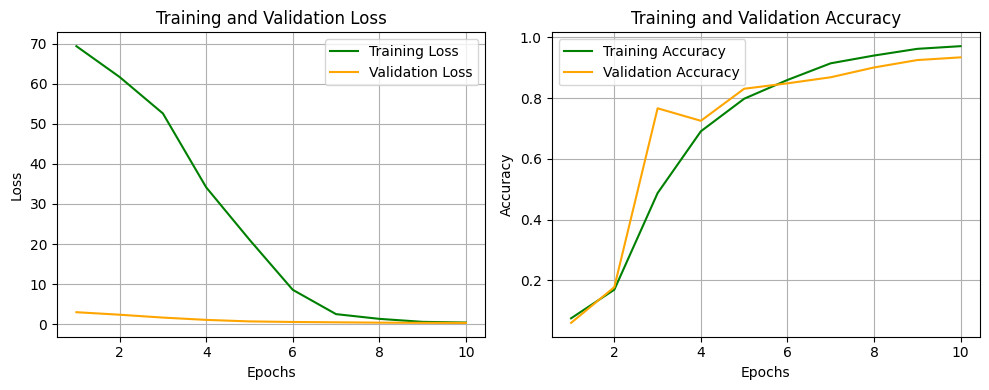

Epoch 1/10
128/128 [==============================] - 25s 173ms/step - loss: 71.9548 - accuracy: 0.6314 - val_loss: 3.0089 - val_accuracy: 0.0222
Epoch 2/10
128/128 [==============================] - 22s 173ms/step - loss: 66.2623 - accuracy: 0.0486 - val_loss: 2.4838 - val_accuracy: 0.1122
Epoch 3/10
128/128 [==============================] - 22s 173ms/step - loss: 63.4918 - accuracy: 0.1351 - val_loss: 2.3903 - val_accuracy: 0.0933
Epoch 4/10
128/128 [==============================] - 21s 167ms/step - loss: 53.4353 - accuracy: 0.2261 - val_loss: 1.9281 - val_accuracy: 0.2289
Epoch 5/10
128/128 [==============================] - 22s 171ms/step - loss: 42.5340 - accuracy: 0.3845 - val_loss: 1.7279 - val_accuracy: 0.3422
Epoch 6/10
128/128 [==============================] - 18s 138ms/step - loss: 33.6257 - accuracy: 0.4789 - val_loss: 1.3758 - val_accuracy: 0.4511
Epoch 7/10
128/128 [==============================] - 19s 146ms/step - loss: 25.1885 - accuracy: 0.6162 - val_loss: 1.1608 -

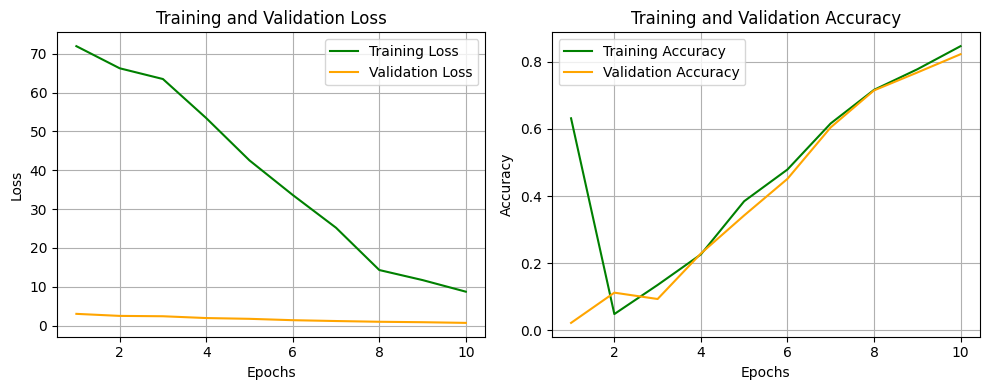

Epoch 1/10
128/128 [==============================] - 21s 155ms/step - loss: 69.7322 - accuracy: 0.0419 - val_loss: 2.8330 - val_accuracy: 0.1833
Epoch 2/10
128/128 [==============================] - 19s 147ms/step - loss: 64.5051 - accuracy: 0.1312 - val_loss: 2.4978 - val_accuracy: 0.1078
Epoch 3/10
128/128 [==============================] - 19s 147ms/step - loss: 59.4980 - accuracy: 0.2315 - val_loss: 2.3832 - val_accuracy: 0.2278
Epoch 4/10
128/128 [==============================] - 18s 142ms/step - loss: 46.3693 - accuracy: 0.3698 - val_loss: 1.7566 - val_accuracy: 0.4944
Epoch 5/10
128/128 [==============================] - 18s 140ms/step - loss: 35.7194 - accuracy: 0.5130 - val_loss: 1.5219 - val_accuracy: 0.5333
Epoch 6/10
128/128 [==============================] - 20s 155ms/step - loss: 26.5128 - accuracy: 0.6148 - val_loss: 1.2629 - val_accuracy: 0.5778
Epoch 7/10
128/128 [==============================] - 20s 156ms/step - loss: 18.9646 - accuracy: 0.6552 - val_loss: 1.0241 -

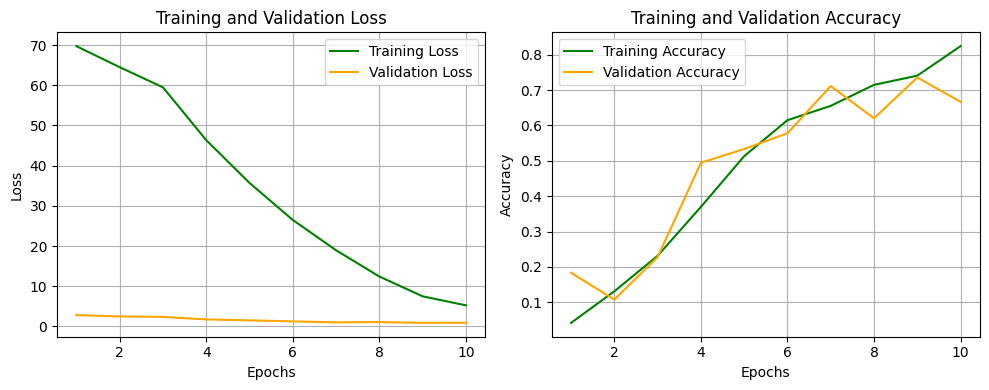

Epoch 1/10
128/128 [==============================] - 19s 138ms/step - loss: 68.6427 - accuracy: 0.0169 - val_loss: 3.0850 - val_accuracy: 0.0444
Epoch 2/10
128/128 [==============================] - 17s 132ms/step - loss: 67.3394 - accuracy: 0.0248 - val_loss: 2.7746 - val_accuracy: 0.0767
Epoch 3/10
128/128 [==============================] - 17s 132ms/step - loss: 66.1264 - accuracy: 0.1400 - val_loss: 2.4009 - val_accuracy: 0.3333
Epoch 4/10
128/128 [==============================] - 15s 119ms/step - loss: 50.2784 - accuracy: 0.3919 - val_loss: 1.5306 - val_accuracy: 0.5778
Epoch 5/10
128/128 [==============================] - 16s 125ms/step - loss: 38.8051 - accuracy: 0.5010 - val_loss: 1.7545 - val_accuracy: 0.3811
Epoch 6/10
128/128 [==============================] - 22s 171ms/step - loss: 31.5617 - accuracy: 0.5569 - val_loss: 1.3613 - val_accuracy: 0.5456
Epoch 7/10
128/128 [==============================] - 21s 162ms/step - loss: 23.2084 - accuracy: 0.6231 - val_loss: 1.2997 -

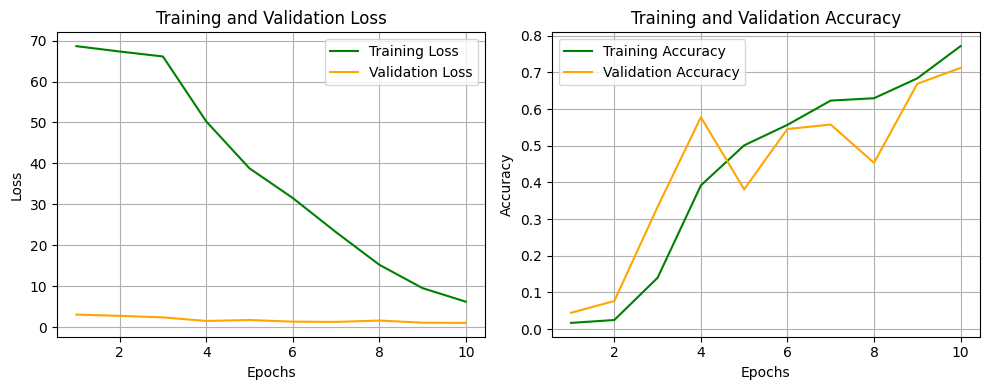

In [23]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

embedding_dim = 500
results = []
for configuracio in range(1,7):
    accuracy_val, accuracy_test, f1_score_val, f1_score_test, history = model(train_pad_sequences, val_pad_sequences, test_pad_sequences, train_encoded_labels, val_encoded_labels, test_encoded_labels,
                         20000+1, embedding_dim, max_sequence_length, num_classes, configuracio)
    results.append({
        'Configuració': configuracio,
        'val_accuracy': accuracy_val,
        'test_accuracy': accuracy_test,
        'f1_score_val': f1_score_val,
        'f1_score_test': f1_score_test
    })
    plot_curves(history)

In [25]:
# Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

 Configuració  val_accuracy  test_accuracy  f1_score_val  f1_score_test
            2      0.957778       0.929054      0.796809       0.665187
            1      0.920000       0.916667      0.720262       0.674096
            3      0.934444       0.907658      0.694650       0.601483
            4      0.822222       0.829955      0.512057       0.467910
            5      0.666667       0.744369      0.460982       0.396210
            6      0.712222       0.724099      0.446635       0.427476


### 4. Recurrents

Provem diferents configuracions amb xarxes recurrents.

In [ ]:
def model(X_train, X_val, X_test, y_train, y_val, y_test, vocab_size, embedding_dim, max_sequence_length, num_classes, config):

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

    if config == 1:
        model.add(LSTM(128))

    elif config == 2:
        model.add(GRU(128))

    elif config == 3:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))

    elif config == 4:
        model.add(LSTM(128, return_sequences=True))
        model.add(GRU(64))

    elif config == 5:
        model.add(Conv1D(64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(128))
    
    elif config == 6:
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))

    elif config == 7:
        model.add(Conv1D(64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Bidirectional(LSTM(128)))

    else:
        model.add(GlobalMaxPooling1D())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Calculem els pesos de les classes
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
    class_weight_dict = dict(enumerate(class_weights))

    # Comptem el nombre d'exemples per cada classe
    class_counts = np.bincount(np.argmax(y_train, axis=1))  # Això compta quantes mostres té cada classe
    total_samples = len(y_train)  # Nombre total de mostres

    # Calculem els pesos per a cada classe com la inversa de la freqüència relativa
    manual_class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

    # Train the model
    batch_size = 32
    epochs = 10
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), class_weight=manual_class_weights)

    # Evaluate
    loss_val, accuracy_val = model.evaluate(X_val, y_val, batch_size=batch_size)
    loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=batch_size)

    # F1-SCORE
    val_true_labels = np.argmax(val_encoded_labels, axis=1)
    test_true_labels = np.argmax(test_encoded_labels, axis=1)

    val_predictions = model.predict(val_pad_sequences, batch_size=32)
    test_predictions = model.predict(test_pad_sequences, batch_size=32)

    val_predicted_labels = np.argmax(val_predictions, axis=1)
    test_predicted_labels = np.argmax(test_predictions, axis=1)

    f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
    f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

    return accuracy_val, accuracy_test, f1_score_val, f1_score_test, history

Epoch 1/10
128/128 [==============================] - 26s 183ms/step - loss: 69.3866 - accuracy: 0.0096 - val_loss: 3.0704 - val_accuracy: 0.0144
Epoch 2/10
128/128 [==============================] - 23s 182ms/step - loss: 68.5411 - accuracy: 0.0601 - val_loss: 3.0320 - val_accuracy: 0.1000
Epoch 3/10
128/128 [==============================] - 23s 177ms/step - loss: 68.2020 - accuracy: 0.0304 - val_loss: 3.0632 - val_accuracy: 0.0144
Epoch 4/10
128/128 [==============================] - 23s 183ms/step - loss: 68.6596 - accuracy: 0.2308 - val_loss: 3.0789 - val_accuracy: 0.0033
Epoch 5/10
128/128 [==============================] - 23s 182ms/step - loss: 68.3850 - accuracy: 0.0554 - val_loss: 3.0984 - val_accuracy: 0.0067
Epoch 6/10
128/128 [==============================] - 23s 182ms/step - loss: 68.3143 - accuracy: 0.0047 - val_loss: 3.0876 - val_accuracy: 0.0033
Epoch 7/10
128/128 [==============================] - 23s 183ms/step - loss: 68.0598 - accuracy: 0.0638 - val_loss: 2.9841 -

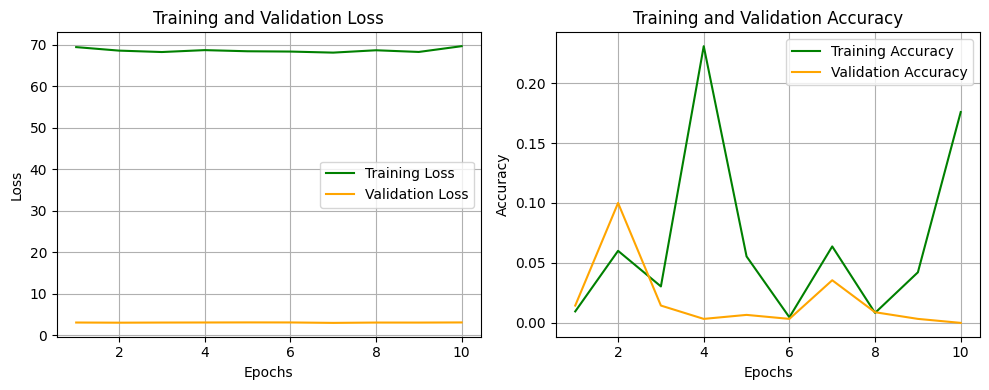

Epoch 1/10
128/128 [==============================] - 23s 164ms/step - loss: 70.2322 - accuracy: 0.0615 - val_loss: 3.0229 - val_accuracy: 0.0067
Epoch 2/10
128/128 [==============================] - 20s 155ms/step - loss: 68.6031 - accuracy: 0.0071 - val_loss: 3.0329 - val_accuracy: 0.0089
Epoch 3/10
128/128 [==============================] - 20s 156ms/step - loss: 68.7830 - accuracy: 0.0123 - val_loss: 3.0936 - val_accuracy: 0.0067
Epoch 4/10
128/128 [==============================] - 20s 155ms/step - loss: 68.4613 - accuracy: 0.0078 - val_loss: 3.0516 - val_accuracy: 0.0089
Epoch 5/10
128/128 [==============================] - 20s 156ms/step - loss: 68.4003 - accuracy: 0.0162 - val_loss: 3.1125 - val_accuracy: 0.0056
Epoch 6/10
128/128 [==============================] - 20s 157ms/step - loss: 68.1464 - accuracy: 0.0181 - val_loss: 3.0722 - val_accuracy: 0.0300
Epoch 7/10
128/128 [==============================] - 20s 157ms/step - loss: 68.3890 - accuracy: 0.0147 - val_loss: 3.0536 -

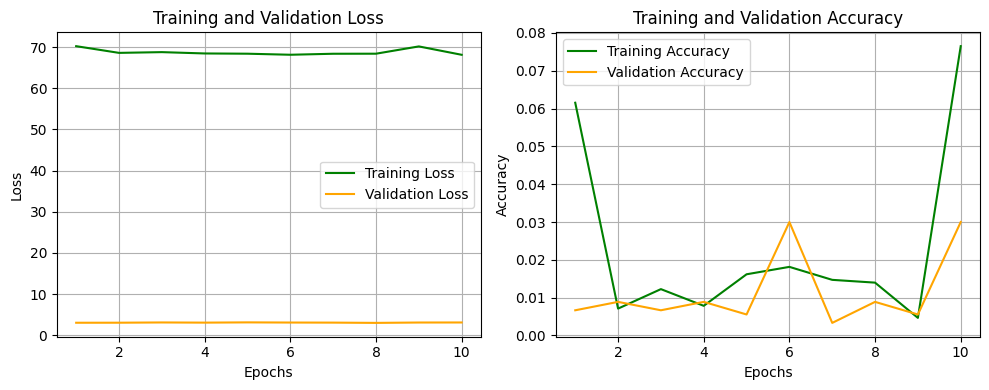

Epoch 1/10
128/128 [==============================] - 31s 214ms/step - loss: 70.1476 - accuracy: 0.0628 - val_loss: 3.0425 - val_accuracy: 0.0011
Epoch 2/10
128/128 [==============================] - 26s 200ms/step - loss: 68.7622 - accuracy: 0.4701 - val_loss: 2.9829 - val_accuracy: 0.7144
Epoch 3/10
128/128 [==============================] - 26s 204ms/step - loss: 68.8009 - accuracy: 0.2006 - val_loss: 3.1190 - val_accuracy: 0.0144
Epoch 4/10
128/128 [==============================] - 26s 204ms/step - loss: 69.1329 - accuracy: 0.0262 - val_loss: 3.0348 - val_accuracy: 0.1000
Epoch 5/10
128/128 [==============================] - 26s 207ms/step - loss: 70.3916 - accuracy: 0.1878 - val_loss: 3.1076 - val_accuracy: 0.0044
Epoch 6/10
128/128 [==============================] - 26s 199ms/step - loss: 69.1065 - accuracy: 0.0066 - val_loss: 3.1940 - val_accuracy: 0.0033
Epoch 7/10
128/128 [==============================] - 26s 204ms/step - loss: 69.2782 - accuracy: 0.0419 - val_loss: 3.1543 -

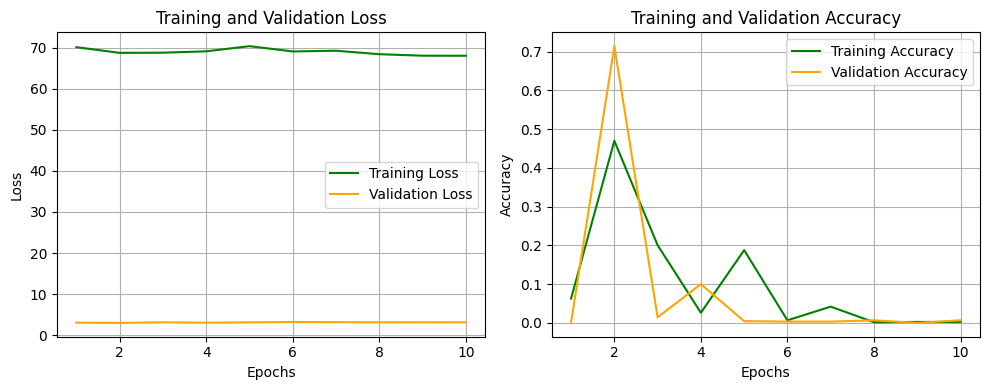

Epoch 1/10
128/128 [==============================] - 31s 217ms/step - loss: 69.4515 - accuracy: 0.1555 - val_loss: 3.0683 - val_accuracy: 0.0578
Epoch 2/10
128/128 [==============================] - 27s 210ms/step - loss: 69.8104 - accuracy: 0.0115 - val_loss: 2.9831 - val_accuracy: 0.0089
Epoch 3/10
128/128 [==============================] - 27s 208ms/step - loss: 68.4697 - accuracy: 0.0978 - val_loss: 2.9528 - val_accuracy: 0.7144
Epoch 4/10
128/128 [==============================] - 27s 211ms/step - loss: 68.6158 - accuracy: 0.0851 - val_loss: 3.1024 - val_accuracy: 0.0011
Epoch 5/10
128/128 [==============================] - 27s 209ms/step - loss: 68.3275 - accuracy: 0.1047 - val_loss: 3.0525 - val_accuracy: 0.0067
Epoch 6/10
128/128 [==============================] - 28s 219ms/step - loss: 68.1524 - accuracy: 0.0083 - val_loss: 3.1025 - val_accuracy: 0.0067
Epoch 7/10
128/128 [==============================] - 31s 246ms/step - loss: 68.3433 - accuracy: 0.0086 - val_loss: 3.0805 -

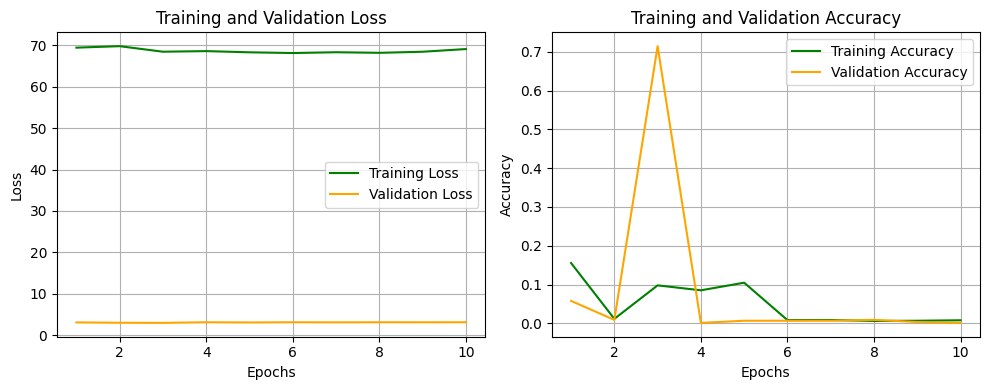

Epoch 1/10
128/128 [==============================] - 25s 183ms/step - loss: 69.8700 - accuracy: 0.0817 - val_loss: 3.0863 - val_accuracy: 0.0067
Epoch 2/10
128/128 [==============================] - 23s 176ms/step - loss: 68.1987 - accuracy: 0.0128 - val_loss: 3.0873 - val_accuracy: 0.0589
Epoch 3/10
128/128 [==============================] - 23s 176ms/step - loss: 68.0758 - accuracy: 0.0277 - val_loss: 3.0910 - val_accuracy: 0.0100
Epoch 4/10
128/128 [==============================] - 22s 176ms/step - loss: 67.4359 - accuracy: 0.1905 - val_loss: 2.7244 - val_accuracy: 0.0289
Epoch 5/10
128/128 [==============================] - 23s 176ms/step - loss: 62.5025 - accuracy: 0.0814 - val_loss: 2.3787 - val_accuracy: 0.2189
Epoch 6/10
128/128 [==============================] - 23s 181ms/step - loss: 64.6622 - accuracy: 0.1665 - val_loss: 1.5433 - val_accuracy: 0.3767
Epoch 7/10
128/128 [==============================] - 20s 154ms/step - loss: 71.9674 - accuracy: 0.0613 - val_loss: 2.9828 -

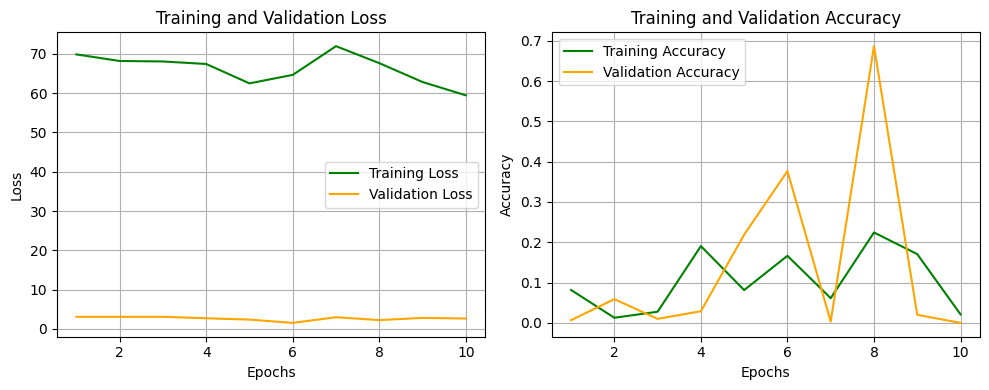

Epoch 1/10
128/128 [==============================] - 42s 291ms/step - loss: 70.2644 - accuracy: 0.0934 - val_loss: 2.8582 - val_accuracy: 0.0656
Epoch 2/10
128/128 [==============================] - 38s 294ms/step - loss: 62.1190 - accuracy: 0.1756 - val_loss: 2.2259 - val_accuracy: 0.2344
Epoch 3/10
128/128 [==============================] - 38s 299ms/step - loss: 49.2550 - accuracy: 0.3485 - val_loss: 1.9006 - val_accuracy: 0.4533
Epoch 4/10
128/128 [==============================] - 41s 319ms/step - loss: 36.1879 - accuracy: 0.5262 - val_loss: 1.1428 - val_accuracy: 0.6978
Epoch 5/10
128/128 [==============================] - 44s 345ms/step - loss: 27.0590 - accuracy: 0.7320 - val_loss: 0.7384 - val_accuracy: 0.7878
Epoch 6/10
128/128 [==============================] - 43s 333ms/step - loss: 16.1191 - accuracy: 0.7469 - val_loss: 0.4908 - val_accuracy: 0.8622
Epoch 7/10
128/128 [==============================] - 44s 346ms/step - loss: 13.0587 - accuracy: 0.7256 - val_loss: 0.8302 -

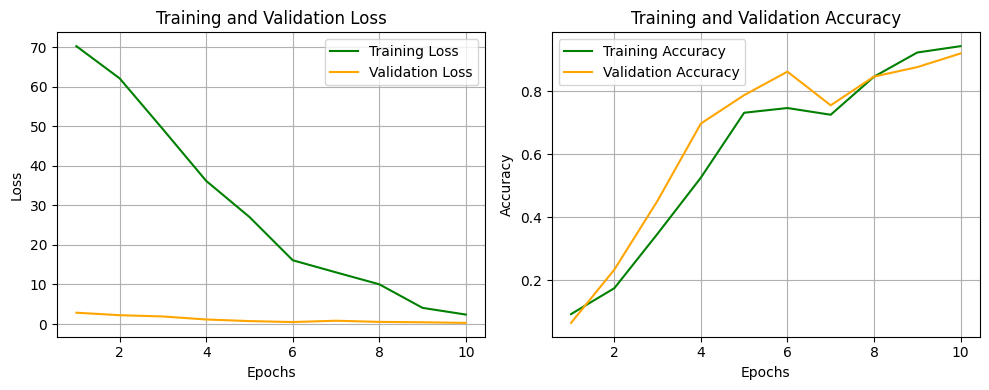

Epoch 1/10
128/128 [==============================] - 43s 292ms/step - loss: 70.6915 - accuracy: 0.2457 - val_loss: 3.0870 - val_accuracy: 0.0411
Epoch 2/10
128/128 [==============================] - 35s 270ms/step - loss: 60.6765 - accuracy: 0.3340 - val_loss: 1.6285 - val_accuracy: 0.7267
Epoch 3/10
128/128 [==============================] - 35s 273ms/step - loss: 43.9844 - accuracy: 0.4448 - val_loss: 2.1193 - val_accuracy: 0.2789
Epoch 4/10
128/128 [==============================] - 34s 268ms/step - loss: 33.5947 - accuracy: 0.4787 - val_loss: 1.1216 - val_accuracy: 0.6367
Epoch 5/10
128/128 [==============================] - 35s 276ms/step - loss: 23.0354 - accuracy: 0.5922 - val_loss: 1.6196 - val_accuracy: 0.3833
Epoch 6/10
128/128 [==============================] - 35s 275ms/step - loss: 14.4557 - accuracy: 0.7258 - val_loss: 0.6347 - val_accuracy: 0.8111
Epoch 7/10
128/128 [==============================] - 33s 260ms/step - loss: 13.1684 - accuracy: 0.8291 - val_loss: 0.6265 -

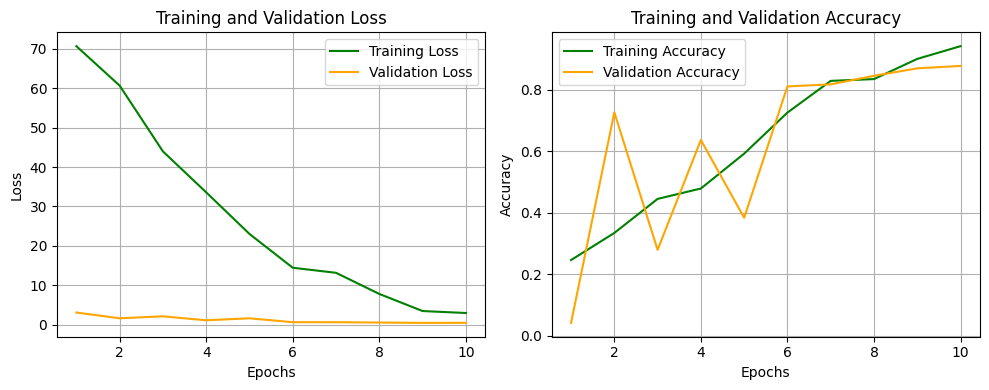

In [40]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

embedding_dim = 500
results = []
for configuracio in range(1,8):
    accuracy_val, accuracy_test, f1_score_val, f1_score_test, history = model(train_pad_sequences, val_pad_sequences, test_pad_sequences, train_encoded_labels, val_encoded_labels, test_encoded_labels,
                         20000+1, embedding_dim, max_sequence_length, num_classes, configuracio)
    results.append({
        'Configuració': configuracio,
        'val_accuracy': accuracy_val,
        'test_accuracy': accuracy_test,
        'f1_score_val': f1_score_val,
        'f1_score_test': f1_score_test
    })
    plot_curves(history)

In [41]:
# Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

 Configuració  val_accuracy  test_accuracy  f1_score_val  f1_score_test
            6      0.920000       0.908784      0.662024       0.581156
            7      0.877778       0.891892      0.601870       0.582372
            2      0.030000       0.037162      0.003434       0.004479
            3      0.006667       0.020270      0.000779       0.002340
            4      0.001111       0.009009      0.000124       0.001015
            1      0.000000       0.000000      0.000000       0.000000
            5      0.000000       0.002252      0.000000       0.002077


### 5. Regularització

In [ ]:
def model(X_train, X_val, X_test, y_train, y_val, y_test, vocab_size, embedding_dim, max_sequence_length, num_classes, config):

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

    if config == 2:
        model.add(Dropout(0.2))
        model.add(MaxPooling1D(pool_size=2))

    elif config == 3:
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))

    elif config == 4:
        model.add(Dropout(0.3))
        model.add(MaxPooling1D(pool_size=2))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))

    elif config == 5:
        model.add(Dropout(0.5))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.5))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))

    if config != 4 and config !=5:
        model.add(GlobalMaxPooling1D())
        model.add(Dense(64, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Calculem els pesos de les classes
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
    class_weight_dict = dict(enumerate(class_weights))

    # Comptem el nombre d'exemples per cada classe
    class_counts = np.bincount(np.argmax(y_train, axis=1))  # Això compta quantes mostres té cada classe
    total_samples = len(y_train)  # Nombre total de mostres

    # Calculem els pesos per a cada classe com la inversa de la freqüència relativa
    manual_class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

    # Train the model
    batch_size = 32
    epochs = 10
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), class_weight=manual_class_weights)

    # Evaluate
    loss_val, accuracy_val = model.evaluate(X_val, y_val, batch_size=batch_size)
    loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=batch_size)

    # F1-SCORE
    val_true_labels = np.argmax(val_encoded_labels, axis=1)
    test_true_labels = np.argmax(test_encoded_labels, axis=1)

    val_predictions = model.predict(val_pad_sequences, batch_size=32)
    test_predictions = model.predict(test_pad_sequences, batch_size=32)

    val_predicted_labels = np.argmax(val_predictions, axis=1)
    test_predicted_labels = np.argmax(test_predictions, axis=1)

    f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
    f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

    return accuracy_val, accuracy_test, f1_score_val, f1_score_test, history

Epoch 1/10
128/128 [==============================] - 19s 141ms/step - loss: 68.1598 - accuracy: 0.4421 - val_loss: 2.6015 - val_accuracy: 0.4611
Epoch 2/10
128/128 [==============================] - 17s 136ms/step - loss: 45.2851 - accuracy: 0.4983 - val_loss: 1.5535 - val_accuracy: 0.7722
Epoch 3/10
128/128 [==============================] - 17s 132ms/step - loss: 25.1323 - accuracy: 0.8200 - val_loss: 1.2800 - val_accuracy: 0.7411
Epoch 4/10
128/128 [==============================] - 17s 132ms/step - loss: 8.2853 - accuracy: 0.8134 - val_loss: 0.7023 - val_accuracy: 0.8567
Epoch 5/10
128/128 [==============================] - 18s 137ms/step - loss: 2.9232 - accuracy: 0.9277 - val_loss: 0.3580 - val_accuracy: 0.9289
Epoch 6/10
128/128 [==============================] - 17s 134ms/step - loss: 1.0666 - accuracy: 0.9534 - val_loss: 0.2816 - val_accuracy: 0.9422
Epoch 7/10
128/128 [==============================] - 17s 135ms/step - loss: 0.6669 - accuracy: 0.9642 - val_loss: 0.2452 - val

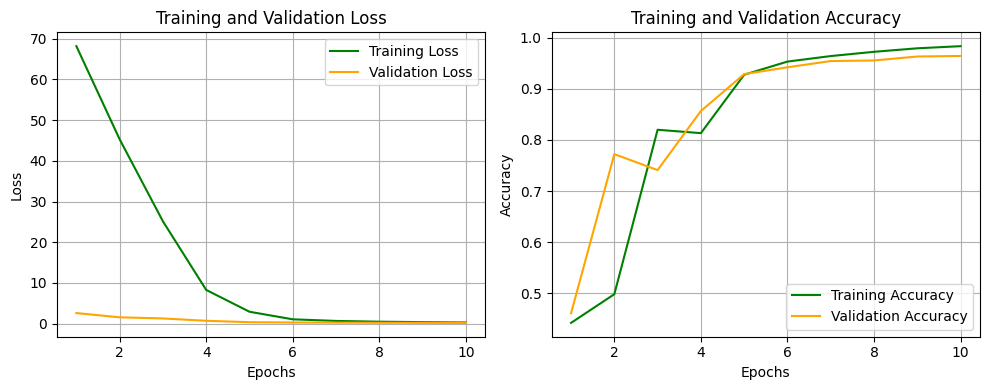

Epoch 1/10
128/128 [==============================] - 19s 142ms/step - loss: 67.4848 - accuracy: 0.5650 - val_loss: 2.6293 - val_accuracy: 0.2889
Epoch 2/10
128/128 [==============================] - 19s 146ms/step - loss: 48.9546 - accuracy: 0.5814 - val_loss: 1.8184 - val_accuracy: 0.5856
Epoch 3/10
128/128 [==============================] - 18s 138ms/step - loss: 30.9007 - accuracy: 0.7867 - val_loss: 1.4023 - val_accuracy: 0.7467
Epoch 4/10
128/128 [==============================] - 17s 135ms/step - loss: 12.1848 - accuracy: 0.8151 - val_loss: 0.7673 - val_accuracy: 0.8578
Epoch 5/10
128/128 [==============================] - 22s 174ms/step - loss: 4.3844 - accuracy: 0.9071 - val_loss: 0.5087 - val_accuracy: 0.9067
Epoch 6/10
128/128 [==============================] - 23s 178ms/step - loss: 1.9816 - accuracy: 0.9340 - val_loss: 0.3876 - val_accuracy: 0.9222
Epoch 7/10
128/128 [==============================] - 16s 129ms/step - loss: 1.4943 - accuracy: 0.9463 - val_loss: 0.3622 - va

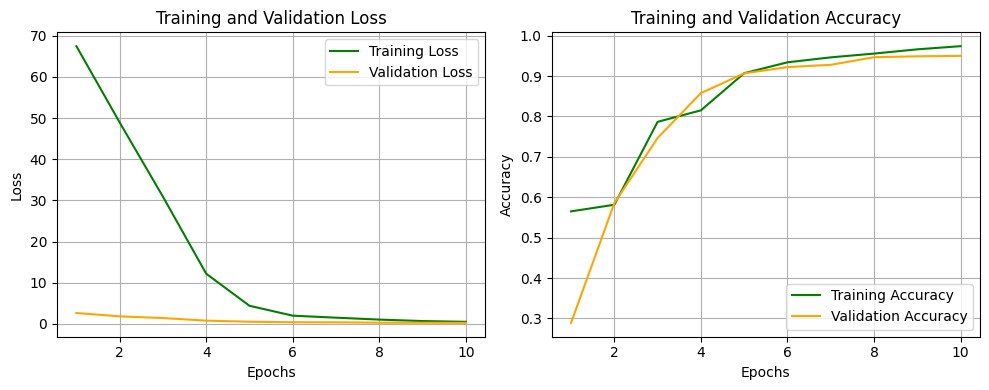

Epoch 1/10
128/128 [==============================] - 17s 126ms/step - loss: 67.8956 - accuracy: 0.1432 - val_loss: 2.7107 - val_accuracy: 0.1733
Epoch 2/10
128/128 [==============================] - 16s 124ms/step - loss: 54.1583 - accuracy: 0.5949 - val_loss: 2.0144 - val_accuracy: 0.4733
Epoch 3/10
128/128 [==============================] - 17s 129ms/step - loss: 32.9675 - accuracy: 0.6653 - val_loss: 1.4474 - val_accuracy: 0.8056
Epoch 4/10
128/128 [==============================] - 16s 128ms/step - loss: 12.3448 - accuracy: 0.7697 - val_loss: 0.9646 - val_accuracy: 0.8144
Epoch 5/10
128/128 [==============================] - 17s 133ms/step - loss: 7.4826 - accuracy: 0.7276 - val_loss: 0.8649 - val_accuracy: 0.8111
Epoch 6/10
128/128 [==============================] - 17s 134ms/step - loss: 3.4672 - accuracy: 0.8789 - val_loss: 0.5731 - val_accuracy: 0.8878
Epoch 7/10
128/128 [==============================] - 18s 141ms/step - loss: 1.8353 - accuracy: 0.9120 - val_loss: 0.4708 - va

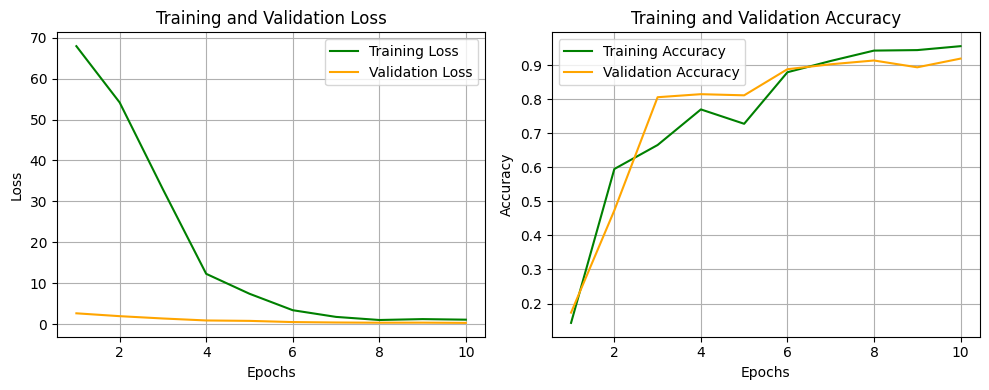

Epoch 1/10
128/128 [==============================] - 18s 136ms/step - loss: 70.2449 - accuracy: 0.1829 - val_loss: 2.7192 - val_accuracy: 0.7167
Epoch 2/10
128/128 [==============================] - 17s 135ms/step - loss: 62.1250 - accuracy: 0.2827 - val_loss: 2.5032 - val_accuracy: 0.3933
Epoch 3/10
128/128 [==============================] - 17s 135ms/step - loss: 57.9478 - accuracy: 0.3919 - val_loss: 2.1000 - val_accuracy: 0.6933
Epoch 4/10
128/128 [==============================] - 18s 139ms/step - loss: 50.2472 - accuracy: 0.4568 - val_loss: 1.8598 - val_accuracy: 0.6656
Epoch 5/10
128/128 [==============================] - 18s 142ms/step - loss: 44.1138 - accuracy: 0.5378 - val_loss: 1.4618 - val_accuracy: 0.7989
Epoch 6/10
128/128 [==============================] - 18s 142ms/step - loss: 29.0093 - accuracy: 0.6116 - val_loss: 1.2333 - val_accuracy: 0.7922
Epoch 7/10
128/128 [==============================] - 19s 148ms/step - loss: 25.5687 - accuracy: 0.6474 - val_loss: 0.9188 -

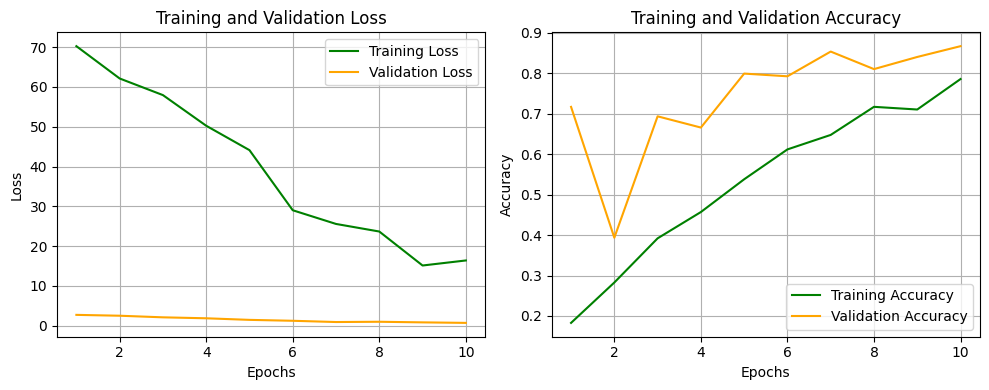

Epoch 1/10
128/128 [==============================] - 22s 159ms/step - loss: 70.8607 - accuracy: 0.2477 - val_loss: 2.7809 - val_accuracy: 0.1056
Epoch 2/10
128/128 [==============================] - 20s 153ms/step - loss: 66.0328 - accuracy: 0.1709 - val_loss: 2.8499 - val_accuracy: 0.2278
Epoch 3/10
128/128 [==============================] - 20s 158ms/step - loss: 66.2904 - accuracy: 0.2281 - val_loss: 2.7121 - val_accuracy: 0.2311
Epoch 4/10
128/128 [==============================] - 20s 156ms/step - loss: 57.7460 - accuracy: 0.2158 - val_loss: 2.5964 - val_accuracy: 0.3989
Epoch 5/10
128/128 [==============================] - 19s 149ms/step - loss: 53.1349 - accuracy: 0.2840 - val_loss: 2.4028 - val_accuracy: 0.4678
Epoch 6/10
128/128 [==============================] - 20s 158ms/step - loss: 50.3948 - accuracy: 0.3210 - val_loss: 2.2084 - val_accuracy: 0.4456
Epoch 7/10
128/128 [==============================] - 19s 150ms/step - loss: 41.5963 - accuracy: 0.3085 - val_loss: 2.1729 -

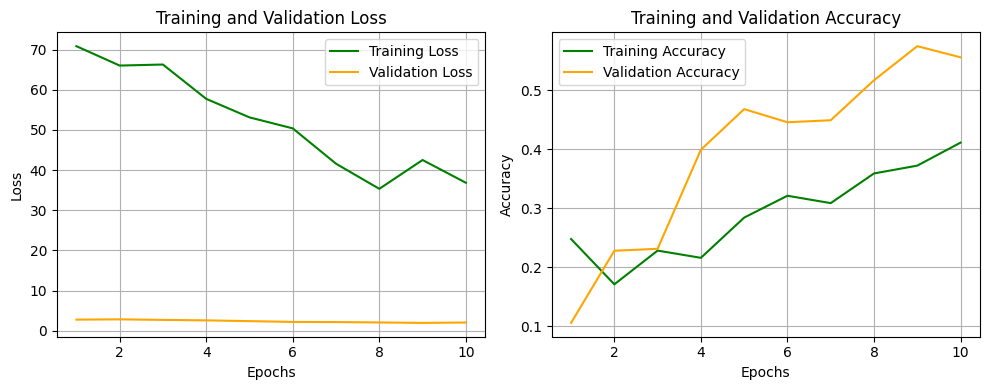

In [44]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

embedding_dim = 500
results = []
for configuracio in range(1,6):
    accuracy_val, accuracy_test, f1_score_val, f1_score_test, history = model(train_pad_sequences, val_pad_sequences, test_pad_sequences, train_encoded_labels, val_encoded_labels, test_encoded_labels,
                         20000+1, embedding_dim, max_sequence_length, num_classes, configuracio)
    results.append({
        'Configuració': configuracio,
        'val_accuracy': accuracy_val,
        'test_accuracy': accuracy_test,
        'f1_score_val': f1_score_val,
        'f1_score_test': f1_score_test
    })
    plot_curves(history)

In [45]:
# Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

 Configuració  val_accuracy  test_accuracy  f1_score_val  f1_score_test
            1      0.964444       0.926802      0.820183       0.670671
            2      0.950000       0.930180      0.754904       0.686089
            3      0.918889       0.913288      0.728809       0.683035
            4      0.866667       0.878378      0.533787       0.592397
            5      0.555556       0.700450      0.325004       0.415977


## Model Final

In [81]:
def model(X_train, X_val, X_test, y_train, y_val, y_test, vocab_size, embedding_dim, max_sequence_length, num_classes):

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Calculem els pesos de les classes
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
    class_weight_dict = dict(enumerate(class_weights))

    # Comptem el nombre d'exemples per cada classe
    class_counts = np.bincount(np.argmax(y_train, axis=1))  # Això compta quantes mostres té cada classe
    total_samples = len(y_train)  # Nombre total de mostres

    # Calculem els pesos per a cada classe com la inversa de la freqüència relativa
    manual_class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

    # Train the model
    batch_size = 32
    epochs = 20
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), class_weight=manual_class_weights)

    # Evaluate
    loss_val, accuracy_val = model.evaluate(X_val, y_val, batch_size=batch_size)
    loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=batch_size)

    # F1-SCORE
    val_true_labels = np.argmax(val_encoded_labels, axis=1)
    test_true_labels = np.argmax(test_encoded_labels, axis=1)

    val_predictions = model.predict(val_pad_sequences, batch_size=32)
    test_predictions = model.predict(test_pad_sequences, batch_size=32)

    val_predicted_labels = np.argmax(val_predictions, axis=1)
    test_predicted_labels = np.argmax(test_predictions, axis=1)

    f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
    f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

    # Calcula la matriu de confusió
    conf_matrix = confusion_matrix(test_true_labels, test_predicted_labels)

    # Normalitza cada fila de la matriu per visualitzar els colors
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_normalized = conf_matrix / row_sums

    # Crea un heatmap amb seaborn, mostrant els valors absoluts però amb colors normalitzats
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=conf_matrix, fmt="d", cmap="Blues", cbar=False,
                xticklabels=np.unique(test_true_labels), yticklabels=np.unique(test_true_labels))

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix with Class-Wise Normalization for Colors")
    plt.show()

    return accuracy_val, accuracy_test, f1_score_val, f1_score_test, history

In [82]:
# Importem les dades de train, val i test
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)  # Les últimes 900 files per al conjunt de validació
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)  # Redefinim el conjunt de train amb les primeres 4078 files
test_data = pd.read_csv('./data/test.csv', header=None)  # Importem les dades de test

# Preprocessem les etiquetes i frases del conjunt de train
train_sentences = list(train_data[0])
train_labels = [s.replace('"', '').replace(' ', '') for s in train_data[2]]

prep_train, tokenizer = preprocessing(train_sentences)

# PROCESSEM PER FER LES PREDICCIONS
# Convertim les frases en seqüències numèriques
train_sequences = tokenizer.texts_to_sequences(prep_train)
max_sequence_length = max(map(len, train_sequences))

# Paddegem les seqüències per fer-les de la mateixa longitud
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Encode les etiquetes del conjunt de train a valors numèrics
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

val_pad_sequences, val_encoded_labels, test_pad_sequences, test_encoded_labels = process_val_test(val_data, test_data, label_encoder)

Epoch 1/20
128/128 [==============================] - 18s 137ms/step - loss: 68.1598 - accuracy: 0.4421 - val_loss: 2.6015 - val_accuracy: 0.4611
Epoch 2/20
128/128 [==============================] - 17s 132ms/step - loss: 45.2851 - accuracy: 0.4983 - val_loss: 1.5535 - val_accuracy: 0.7722
Epoch 3/20
128/128 [==============================] - 16s 127ms/step - loss: 25.1323 - accuracy: 0.8200 - val_loss: 1.2800 - val_accuracy: 0.7411
Epoch 4/20
128/128 [==============================] - 16s 123ms/step - loss: 8.2853 - accuracy: 0.8134 - val_loss: 0.7023 - val_accuracy: 0.8567
Epoch 5/20
128/128 [==============================] - 16s 122ms/step - loss: 2.9232 - accuracy: 0.9277 - val_loss: 0.3580 - val_accuracy: 0.9289
Epoch 6/20
128/128 [==============================] - 16s 124ms/step - loss: 1.0666 - accuracy: 0.9534 - val_loss: 0.2816 - val_accuracy: 0.9422
Epoch 7/20
128/128 [==============================] - 17s 133ms/step - loss: 0.6669 - accuracy: 0.9642 - val_loss: 0.2452 - val

C:\Users\abril\AppData\Local\Temp\ipykernel_5000\1606355273.py:52: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalized = conf_matrix / row_sums


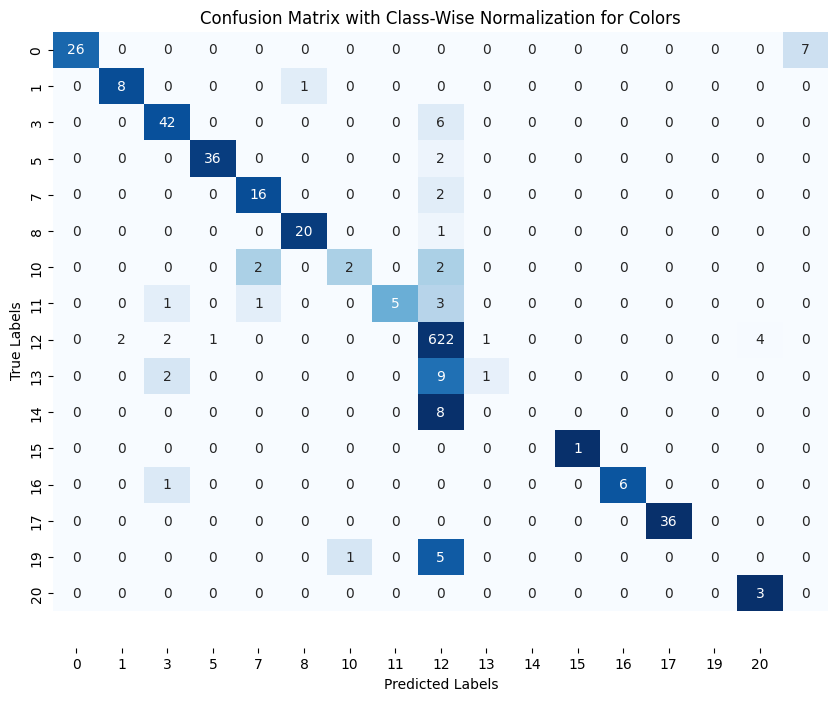

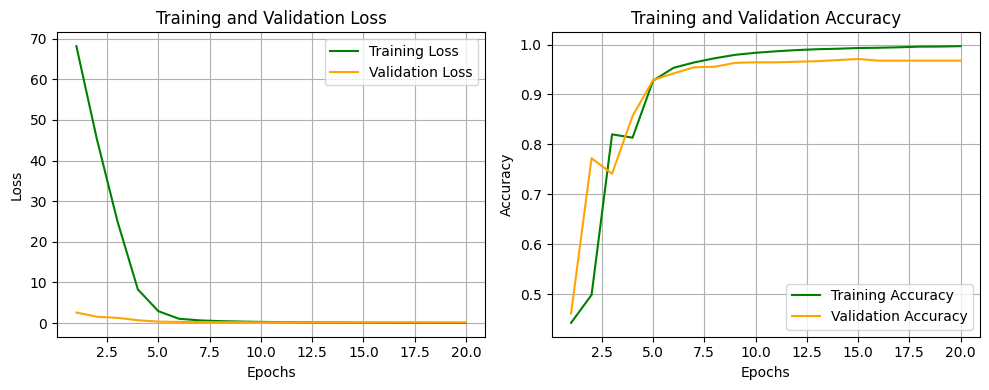

In [83]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

embedding_dim = 500
results = []
accuracy_val, accuracy_test, f1_score_val, f1_score_test, history = model(train_pad_sequences, val_pad_sequences, test_pad_sequences, train_encoded_labels, val_encoded_labels, test_encoded_labels,
                         20000+1, embedding_dim, max_sequence_length, num_classes)
results.append({
    'val_accuracy': accuracy_val,
    'test_accuracy': accuracy_test,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test
})
plot_curves(history)

In [58]:
# Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

 val_accuracy  test_accuracy  f1_score_val  f1_score_test
     0.971111        0.93018      0.823319       0.670503



<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---